In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings(action="ignore")
plt.style.use(["seaborn-bright","dark_background"])

In [2]:
data = pd.read_csv("/content/Stock.csv")
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by="Date")

In [4]:
data.index = data["Date"]

In [5]:
train_size = len(data[:'2017'])

In [6]:
df = data["Close"].reset_index()
df.drop(columns=["Date"],inplace=True)
df.head()

,Close
0,121.55
1,120.90
2,120.65
3,117.60
4,118.65


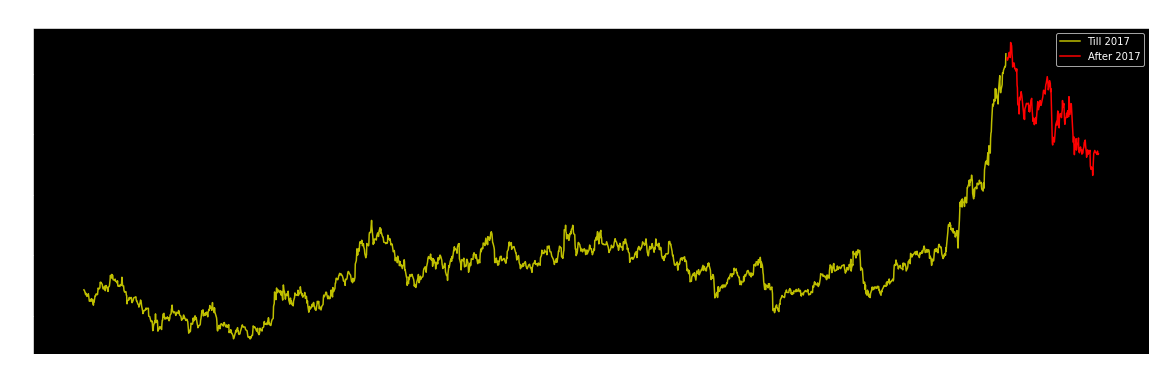

In [7]:
plt.figure(figsize=(20,6))
plt.plot(data['Close'][:'2017'],color="y")
plt.plot(data['Close']['2018':],color="r")
plt.title("Close Price History",fontsize=20)
plt.legend(['Till 2017','After 2017'])
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
df = scale.fit_transform(np.array(df).reshape(-1,1))

In [9]:
test_size = len(df)-train_size
train_data , test_data = df[0:train_size,:],df[train_size:len(df),:1]

In [10]:
train_data.shape, test_data.shape, df.shape

((1850, 1), (185, 1), (2035, 1))

In [11]:
def create_data(lower,upper):
    X = []
    y = []
    time_step = 80
    for i in range(lower,upper):
        X.append(df[i-time_step:i,0])
        y.append(df[i,0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0],X.shape[1],1))
    return X,y

In [12]:
X_train, y_train = create_data(80,train_size)

In [13]:
X_test, y_test = create_data(1850,len(df))

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1770, 80, 1), (1770,), (185, 80, 1), (185,))

In [15]:
from tensorflow import keras
from keras import models
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [16]:
model = models.Sequential()
model.add(LSTM(100, return_sequences=True,input_shape=(80,1)))
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

In [17]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 80, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 80, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 91,251
Trainable params: 91,251
Non-traina

In [18]:
hist = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=80,verbose=1)

Epoch 1/50
23/23 [==============================] - 16s 368ms/step - loss: 0.0127 - val_loss: 0.0035
Epoch 2/50
23/23 [==============================] - 6s 275ms/step - loss: 0.0016 - val_loss: 0.0493
Epoch 3/50
23/23 [==============================] - 6s 280ms/step - loss: 0.0013 - val_loss: 0.0124
Epoch 4/50
23/23 [==============================] - 5s 232ms/step - loss: 0.0011 - val_loss: 0.0107
Epoch 5/50
23/23 [==============================] - 7s 321ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 6/50
23/23 [==============================] - 5s 233ms/step - loss: 0.0010 - val_loss: 0.0156
Epoch 7/50
23/23 [==============================] - 8s 357ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 8/50
23/23 [==============================] - 6s 255ms/step - loss: 9.2149e-04 - val_loss: 0.0059
Epoch 9/50
23/23 [==============================] - 11s 472ms/step - loss: 9.8037e-04 - val_loss: 0.0117
Epoch 10/50
23/23 [==============================] - 10s 449ms/step - loss: 0.0011 - val_l

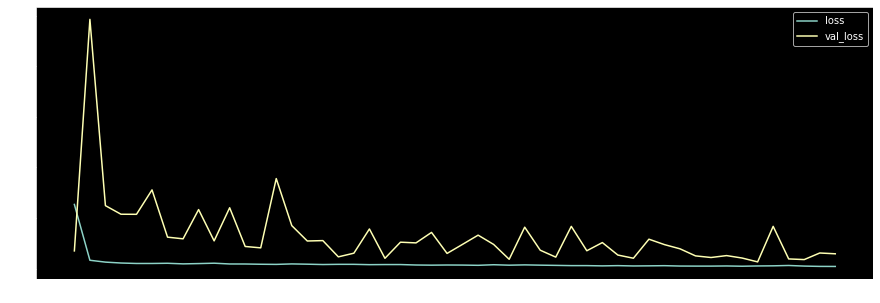

In [19]:
pd.DataFrame(hist.history).plot(figsize=(15,5))
plt.grid(False)
plt.show()

In [20]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [21]:
train_pred = scale.inverse_transform(train_pred)
test_pred = scale.inverse_transform(test_pred)

In [22]:
print(f'Training error : {np.sqrt(mean_squared_error(y_train,train_pred))}')

Training error : 142.7438835473041


In [23]:
df1 = pd.DataFrame(data['Close']).iloc[80:,:]

In [24]:
predicted = []
predicted.extend(train_pred)
predicted.extend(test_pred)

In [25]:
df1['Predicted'] = predicted

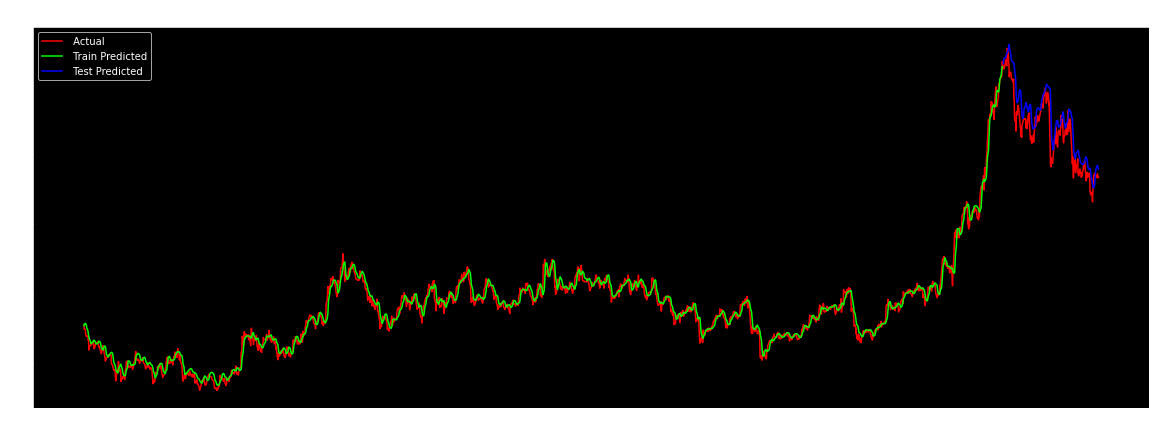

In [26]:
plt.figure(figsize=(20,7))
plt.plot(df1['Close'],color='r')
plt.plot(df1['Predicted'].iloc[:train_size-80],color = 'lime')
plt.plot(df1['Predicted'].iloc[train_size-80:],color = 'b')
plt.legend([' Actual',' Train Predicted',' Test Predicted'],loc="upper left")
plt.title('Actual vs Predicted',fontsize=20)
plt.show()